### 필요한 라이브러리 다운로드

In [63]:
!pip install -qU openai langchain langchain-upstage langchain-chroma getpass4

# Upstage API Key 입력

In [64]:
# @title set API key
import os
import getpass
import warnings

warnings.filterwarnings("ignore")

# Get the Upstage API key using getpass
if "UPSTAGE_API_KEY" not in os.environ or not os.environ["UPSTAGE_API_KEY"]:
    os.environ["UPSTAGE_API_KEY"] = getpass.getpass("Enter your Upstage API key: ")

print("API key has been set successfully.")

API key has been set successfully.


# csv -> Vector
## 문단 리스트 준비

In [88]:
# allergies.csv 읽기 (알러지 반응 기록)
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document
import pandas as pd
from typing import List
df = pd.read_csv("allergies.csv")


# 환자별로 그룹화
grouped = df.groupby("PATIENT")

# 문서 리스트
allergy_docs = []

for patient_id, group in grouped:
    text_lines = []
    for _, row in group.iterrows():
        # 한 줄 설명 생성
        line = (
            f"{row['START'][:10]}부터 현재까지 "
            f"{row['DESCRIPTION']}({row['CODE']})에 대한 알레르기를 보였습니다. "
            f"이 알레르기는 {row['CATEGORY']} 카테고리에 속하며, "
            f"코드 체계는 {row['SYSTEM']}입니다."
        )
        if pd.notnull(row['DESCRIPTION1']):
            line += f" 첫 번째 반응은 {row['DESCRIPTION1']}로, 심각도는 {row['SEVERITY1']}입니다."
        if pd.notnull(row['DESCRIPTION2']):
            line += f" 두 번째 반응은 {row['DESCRIPTION2']}로, 심각도는 {row['SEVERITY2']}입니다."

        text_lines.append(line)

    # 전체 문서 구성
    combined_text = f"환자 ID: {patient_id[:8]}\n환자는 다음과 같은 알레르기 반응을 보였습니다:\n" + "\n".join(text_lines)

    # Document 생성
    allergy_docs.append(Document(page_content=combined_text, metadata={"patient_id": patient_id[:8], "table": "allergies"}))

print("환자 수 (문서 수):", len(allergy_docs))

환자 수 (문서 수): 202


In [104]:
# medications.csv 읽기 (약물 투여 기록)
df = pd.read_csv("medications.csv")

# 환자 id 별로 그룹으로 묶을 예정
grouped = df.groupby("PATIENT")

medication_docs = []
for patient_id, group in grouped:
    text_lines = []
    for _, row in group.iterrows():
        line = f"{row['START'][:10]}부터 {row['STOP'][:10]+'까지' if pd.notnull(row['STOP']) else '현재까지'} " \
               f"{row['DESCRIPTION']}을 총 {row['DISPENSES']}회 복용했습니다."
        text_lines.append(line)
    combined_text = f"환자 ID : {patient_id[:8]}\n환자는 다음 약물을 복용했습니다:\n" + "\n".join(text_lines)
    medication_docs.append(Document(page_content=combined_text, metadata={"patient_id": patient_id[:8], "table" : "medications"}))

print("환자 수 (문서 수):", len(medication_docs))

환자 수 (문서 수): 1158


## Chunking 작업

In [90]:
# allergies.csv
allergy_text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=250,
    chunk_overlap=0
)

# 청킹 수행
allergy_splits = allergy_text_splitter.split_documents(allergy_docs)

# 결과 확인
print("총 청크 수:", len(allergy_splits))
print("예시 청크 내용:")
print(allergy_splits[0].page_content)

총 청크 수: 922
예시 청크 내용:
환자 ID: 01512022
환자는 다음과 같은 알레르기 반응을 보였습니다:
2004-02-08부터 현재까지 Allergic disposition (finding)(609328004.0)에 대한 알레르기를 보였습니다. 이 알레르기는 environment 카테고리에 속하며, 코드 체계는 SNOMED-CT입니다.


In [105]:
# medications.csv
medication_text_splitter = RecursiveCharacterTextSplitter(
    chunk_size= 1000,
    chunk_overlap=0
)

# 청킹 실행
medication_splits = medication_text_splitter.split_documents(medication_docs)

# 결과 확인
print("총 청크 수:", len(medication_splits))
print("첫 번째 청크 예시:")
print(medication_splits[0].page_content)


총 청크 수: 6207
첫 번째 청크 예시:
환자 ID : 0063c9a6
환자는 다음 약물을 복용했습니다:
2000-03-15부터 2001-03-21까지 lisinopril 10 MG Oral Tablet을 총 4회 복용했습니다.
2001-01-09부터 2001-02-03까지 Naproxen sodium 220 MG Oral Tablet을 총 1회 복용했습니다.
2001-03-21부터 2002-03-27까지 lisinopril 10 MG Oral Tablet을 총 4회 복용했습니다.
2001-04-04부터 2001-04-04까지 sodium fluoride 0.0272 MG/MG Oral Gel을 총 1회 복용했습니다.
2002-03-27부터 2003-04-02까지 lisinopril 10 MG Oral Tablet을 총 4회 복용했습니다.
2003-04-02부터 2004-04-07까지 lisinopril 10 MG Oral Tablet을 총 4회 복용했습니다.
2003-04-23부터 2009-05-28까지 Simvastatin 10 MG Oral Tablet을 총 10회 복용했습니다.
2004-04-07부터 2005-04-13까지 lisinopril 10 MG Oral Tablet을 총 4회 복용했습니다.
2004-04-22부터 2005-05-04까지 Simvastatin 10 MG Oral Tablet을 총 12회 복용했습니다.
2004-06-16부터 2004-06-27까지 Penicillin V Potassium 500 MG Oral Tablet을 총 1회 복용했습니다.
2005-04-13부터 2006-04-19까지 lisinopril 10 MG Oral Tablet을 총 4회 복용했습니다.
2005-05-04부터 2006-05-04까지 Simvastatin 10 MG Oral Tablet을 총 12회 복용했습니다.
2006-04-19부터 2007-04-25까지 lisinopril 10 MG Oral Tablet을 총 4회 복용했습니다.


## Plot 시각화

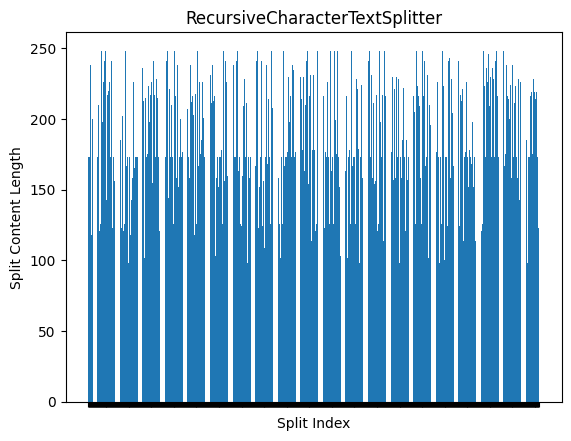

In [102]:
import matplotlib.pyplot as plt
split_lengths = [len(split.page_content) for split in allergy_splits]

plt.bar(range(len(split_lengths)), split_lengths)
plt.title("RecursiveCharacterTextSplitter")
plt.xlabel("Split Index")
plt.ylabel("Split Content Length")
plt.xticks(range(len(split_lengths)), [])
plt.show()

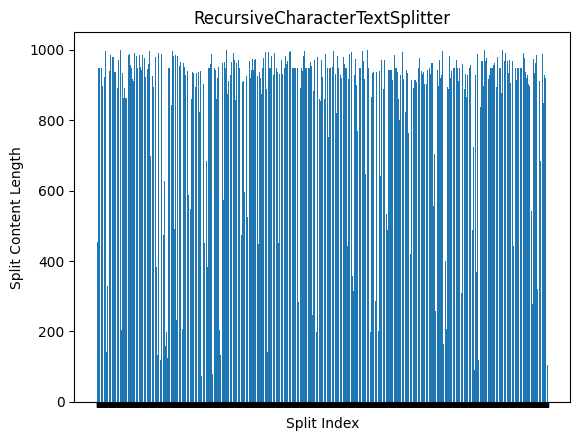

In [103]:
split_lengths = [len(split.page_content) for split in medication_splits]

plt.bar(range(len(split_lengths)), split_lengths)
plt.title("RecursiveCharacterTextSplitter")
plt.xlabel("Split Index")
plt.ylabel("Split Content Length")
plt.xticks(range(len(split_lengths)), [])
plt.show()

## Vector DB 저장

In [ ]:
from langchain_chroma import Chroma
from langchain_upstage import UpstageEmbeddings
from langchain.docstore.document import Document



# 1️⃣ Embeddings 객체 선언
embeddings = UpstageEmbeddings(model="embedding-query")

# 2️⃣ Chroma 벡터 DB 생성 및 문서 삽입
patient_vectorstore = Chroma.from_documents(
    documents=patient_splits,
    embedding=embeddings,
    persist_directory="./chroma_patients"
)

In [ ]:


# allergies.csv
allergy_vectorstore = Chroma.from_documents(
    documents= allergy_splits,
    embedding=embeddings,
    persist_directory= "./chroma_allergies"

)

Mounted at /content/drive


ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


In [ ]:
# 1️⃣ 기존에 잘못된 DB 폴더 제거
!rm -rf ./chroma_medications

# 2️⃣ 다시 생성 (from_documents → persist까지)
medication_vectorstore = Chroma.from_documents(
    documents=medication_splits,
    embedding=embeddings,
    persist_directory="/content/chroma_medications"
)


In [ ]:
# 파일 다운로드
import shutil
from google.colab import files

# 📁 압축할 폴더 경로 (예: ./saved_chroma_db)
folder_path = '/content/chroma_medications'
zip_filename = 'chroma_medications.zip'

# 📦 폴더를 zip 파일로 압축
shutil.make_archive(base_name=zip_filename.replace(".zip", ""), format='zip', root_dir=folder_path)

# ⬇️ zip 파일 다운로드
files.download(zip_filename)

# 데이터 불러오기

In [ ]:
from langchain_chroma import Chroma
from langchain_upstage import UpstageEmbeddings

embeddings = UpstageEmbeddings(model="embedding-query")

allergy_vectorstore = Chroma(
    persist_directory="./chroma_allergies_db",
    embedding_function=embeddings
)

ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


In [ ]:
condition_vectorstore = Chroma(
    persist_directory="./chroma_conditions_db",
    embedding_function=embeddings
)

ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


In [ ]:
medication_vectorstore = Chroma(
    persist_directory="./chroma_medications_db",
    embedding_function=embeddings
)

ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


In [ ]:
observation_vectorstore = Chroma(
    persist_directory="./chroma_observations_db",
    embedding_function=embeddings
)

ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


In [ ]:
patient_vectorstore = Chroma(
    persist_directory="./chroma_patients_db",
    embedding_function=embeddings
)

ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


# LLM 생성

In [ ]:
# allergies.csv
allergy_retriever = allergy_vectorstore.as_retriever(
    search_type='mmr',
    search_kwargs={'k': 1},

)


In [ ]:
# conditions.csv
condition_retriever = condition_vectorstore.as_retriever(
    search_type='similarity',
    search_kwargs={'k': 2},

)


In [ ]:
# medications.csv
medication_retriever = medication_vectorstore.as_retriever(
    search_type='mmr',
    search_kwargs={'k': 3},

)


In [ ]:
# observations.csv
observation_retriever = observation_vectorstore.as_retriever(
    search_type='similarity_score_threshold',
    search_kwargs={'k': 10, 'score_threshold':0.5},

)


In [ ]:
# patients.csv
patient_retriever = patient_vectorstore.as_retriever(
    search_type='similarity',
    search_kwargs={'k': 1},

)


In [ ]:
# ✅ 사용자의 한국어 질문 예시"
#query = "28세 남성이 축구 경기 중 쇄골 골절을 입었다. 수술적 치료를 받은 후 가장 흔히 발생할 수 있는 하드웨어 관련 합병증은 무엇인가?  \n1) 혈전 형성  \n2) 하드웨어 돌출 및 불편감  \n3) 신경 손상  \n4) 폐 손상  \n5) 감염"

In [ ]:

# ✅ 검색된 문서 가져오기
questions = []
answers = []
contexts = []

# ✅ 한국어 system 프롬프트 정의
from langchain_upstage import ChatUpstage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

llm = ChatUpstage()

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
                당신은 환자 정보에 대한 질문에 친절히 답변하는 한국어 의료 AI 어시스턴트입니다.
                아래 CONTEXT 정보를 참고하여 환자 정보를 자연스럽고 이해하기 쉽게 한국어로 풀어서 설명해 주세요.
                CONTEXT 정보는 총 5가지로 제공됩니다. 각각은 순서대로 환자 기본 정보, 진단된 질병 정보, 약물 투약 기록, 알레르기 반응 기록, 바이탈 수치 및 검사 결과입니다.
                같은 환자의 정보를 PATIENT_ID 기준으로 연결해서 참고하세요.
                만약 해당 환자에 대한 직접적인 정보가 없을 경우, 유사한 환자의 사례를 바탕으로 설명해 주세요.
                답변은 다음 지침에 따라 작성해 주세요:

                - 질문자의 상태에 가장 유사한 환자 사례를 바탕으로 설명해 주세요.
                - 특정 질환이나 증상에 대해, 유사 환자들이 어떤 진단과 약물 처방을 받았는지 자연스럽게 제안하는 형태로 작성해 주세요.
                    - 예:“이와 비슷한 환자의 경우, 항히스타민제인 로라타딘을 복용한 사례가 있습니다.”
                - 약물 이름, 질병명, 검사 항목 등 영어 표현이 포함된 경우 한국어로 병기하고, 필요시 쉬운 설명을 덧붙여 주세요.
                - 응답은 의료진이 환자에게 설명하듯 부드럽고 자연스럽게 작성해 주세요.
                - 문장은 단정 짓기보다는“~할 수 있습니다" , "~가 도움이 될 수 있습니다"처럼 제안형으로 작성해 주세요.
                - 너무 긴 목록은 피하고, 중요한 정보를 중심으로 요약해 주세요.
                - 정보가 부족하거나 모르는 경우에는 솔직하게 “정확한 정보가 없어 말씀드리기 어렵습니다”라고 알려 주세요.

            ---
            CONTEXT:
            {context}
            """,
        ),
        ("human", "{input}"),
    ]
)

# ✅ LLM chain 구성
chain = prompt | llm | StrOutputParser()

my_queries = [
    "Duchenne muscular dystrophy(DMD) 환자에서 보조기와 기립 장치의 효과를 평가하기 위한 연구의 필요성에 대한 이유로 가장 적절한 것은?  \n1) DMD 환자의 골밀도 감소 예방에 대한 효과가 아직 명확히 확립되지 않았다.  \n2) 기립 장치 사용이 DMD 환자의 삶의 질 향상에 미치는 영향이 충분히 연구되지 않았다.  \n3) 현재 DMD 환자에서 기립 장치의 효과를 평가한 무작위 대조 연구(RCT)가 부족하다.  \n4) 보조기의 사용이 DMD 환자의 스콜리오시스 발달에 미치는 영향을 명확히 규명할 필요가 있다.  \n5) DMD 환자에서 기립 장치의 사용이 근골격계 통증을 유발하는지에 대한 근거가 부족하다.",
    "만성 원발성 요통 환자에게 제공할 수 있는 비약물적 중재로 '구조화된 운동 요법'이 권장되는 주요 이유는 무엇인가?  \n1) 체중 관리에 효과적이기 때문  \n2) 통증을 완화하고 신체 기능을 개선하기 때문  \n3) 빠른 통증 완화를 제공하기 때문  \n4) 수술적 개입을 피하기 때문  \n5) 심리적 스트레스를 줄이기 때문",
    "28세 남성이 축구 경기 중 쇄골 골절을 입었다. 수술적 치료를 받은 후 가장 흔히 발생할 수 있는 하드웨어 관련 합병증은 무엇인가?  \n1) 혈전 형성  \n2) 하드웨어 돌출 및 불편감  \n3) 신경 손상  \n4) 폐 손상  \n5) 감염"


]


for query in my_queries:

    allergy_docs = allergy_retriever.invoke(query)

    condition_docs = condition_retriever.invoke(query)

    medication_docs = medication_retriever.invoke(query)

    observation_docs = observation_retriever.invoke(query)

    patient_docs = patient_retriever.invoke(query)

# all_context = "\n".join([
#     doc.page_content for doc in ( allergy_docs + condition_docs + medication_docs + observation_docs + patient_docs)
# ])
# all_context = "\n".join([
#     doc.page_content for doc in (patient_docs)
# ])

    all_docs_sorted = patient_docs + condition_docs + medication_docs + allergy_docs + observation_docs
    context_list = [doc.page_content for doc in all_docs_sorted]
    context_str = "\n".join(context_list)



# ✅ 최종 chain 호출
    response = chain.invoke({"context": context_str, "input": query})
    questions.append(query)
    answers.append(response)
    contexts.append(context_list)
# print("\n💬 AI의 답변:")
# print(response)


NameError: name 'my_queries' is not defined

TMI: 여기까지 돌리는 데 Billing 0.05$ 사용
### Now What?
GPT 추천:
# ✅ 💡 선택지 크게 두 가지

## 🅰️ **전부 조인 후 넣기 (One big chunk)**

### ✔️ 장점

* 환자 한 명에 대한 정보가 하나의 청크에 모두 담김 → 질문할 때 정확한 컨텍스트 제공
* 질병, 약물, 투약 주의사항 등을 한 번에 설명하기 쉬움

### ❌ 단점

* row 폭발 (조인한 경우 레코드 수 \* 약물 수 \* 진단 수 …)
* 청크가 너무 커짐 → 나눠야 할 때 문맥이 깨짐
* 관리/업데이트 어려움

---

## 🅱️ **테이블별로 분리, Retriever에서 동적 컨텍스트 결합 (멀티-벡터 전략)**

### ✔️ 장점

* 각 테이블 정보 독립적으로 유지
* 스케일 확장 유리 (예: 약물 DB 업데이트, 질환 DB 변경 등)
* Retriever 단계에서 동적으로 "다중 소스" 컨텍스트 결합 가능

### ❌ 단점

* QA 정확도를 높이려면 "적절한 컨텍스트 조합 로직" 필요
* LLM 프롬프트 설계가 복잡

---

# ✅ 💡 현업과 연구에서 많이 쓰는 전략: **멀티-벡터 & 멀티-Retriever 방식**

### 💡 구조

```
[벡터 DB A] ← 환자 정보 테이블 (예: Patient Demographics)
[벡터 DB B] ← 질병 정보 테이블 (예: Diagnoses)
[벡터 DB C] ← 약물 정보 테이블 (예: Medications)
```

---

## ✅ 1️⃣ 각 테이블별로 개별 벡터 DB 구축

* 각 테이블 row 단위로 Document 생성 → 독립 embedding
* 예:

```python
patient_docs = [Document(page_content="환자 A: 60세, 남성, 당뇨, 고혈압", metadata={"patient_id": "A"})]
diagnosis_docs = [Document(page_content="환자 A: 진단명: 당뇨병, HbA1c: 8.5%", metadata={"patient_id": "A"})]
medication_docs = [Document(page_content="환자 A: 메트포르민 투약 중", metadata={"patient_id": "A"})]
```

---

## ✅ 2️⃣ Retriever 여러 개 선언

```python
patient_retriever = patient_vectorstore.as_retriever(search_kwargs={'k': 1})
diagnosis_retriever = diagnosis_vectorstore.as_retriever(search_kwargs={'k': 1})
medication_retriever = medication_vectorstore.as_retriever(search_kwargs={'k': 1})
```

---

## ✅ 3️⃣ 질문 시, **각 Retriever에서 병렬 검색 → 결과 컨텍스트 합침**

```python
patient_docs = patient_retriever.invoke(query)
diagnosis_docs = diagnosis_retriever.invoke(query)
medication_docs = medication_retriever.invoke(query)

all_context = "\n".join([
    doc.page_content for doc in (patient_docs + diagnosis_docs + medication_docs)
])
```

---

## ✅ 4️⃣ LLM에 합쳐진 context 전달

```python
response = chain.invoke({"context": all_context, "input": query})
```

---

# ✅ 💬 **실제 사용 시 포인트**

| 고려 사항         | 내용                                                                      |
| ------------- | ----------------------------------------------------------------------- |
| ✅ 컨텍스트 길이     | 여러 테이블 합치면 길어질 수 있음 → 필요하면 각 테이블에서 `k` 값을 줄이거나 요약 추가                    |
| ✅ metadata 활용 | `patient_id`, `diagnosis_id` 등으로 cross-link → 필터 기반 검색 강화 가능            |
| ✅ 프롬프트 설계     | "아래에 환자 기본정보, 질병정보, 약물정보가 있습니다. 이 환자에게 적합한 약물과 투약 시 주의사항을 종합적으로 알려주세요." |

---

# ✅ ✅ 💡 **요약**

### 💡 다 조인? ❌

* 데이터 폭발, 관리 불가

### 💡 테이블별 분리 & Retriever에서 조합? ✅

* 유연, scalable, 관리 쉽고, 정확도 높음

---

In [ ]:
!rm -rf chroma_medications  # 잘못된 DB 폴더 삭제
!mkdir chroma_medications